Демонстрация простой вариационной модели и ее прунинга.

**Disclaimer**: могут быть ошибки, кроме того, функии могут быть написаны неоптимально.

In [48]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms

In [49]:
device = 'cpu' # cuda or cpu

In [50]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 20 #количество эпох
lamb = [0, 0.1, 0.5, 1, 5, 10, 100, 1000]
# lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 100 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов
acc_delete = [] 
filename = 'save_array' # куда сохранять

In [51]:
# сохранение данных
def save(file):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()
    
def load(path = filename):
    infile = open(path, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file
    
    

In [52]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [53]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2

In [54]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self):
        k = 0
        for l in self:
            k+=l.KLD()
        return k

In [55]:
def train_batches(net, loss_fn, optimizer, i, lam, out, out_loss, kld, loss):
    for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad()   
            out[i] = net(x)
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
            out_loss[i] = loss_fn(out[i], y)* len(train_data)         
            kld[i] =  net.KLD() * lam        
            loss[i] = (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data)            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()

In [56]:
def statistic(net, loss_fn, i, kld, loss, out, out_loss):
    net.eval()  
    kld[i] =  net.KLD() 
    loss[i] = kld[i]
    for x,y in test_loader:
         if device == 'cuda':
            x = x.cuda()
            y = y.cuda()          
    out[i] = net(x)   
    out_loss[i] = loss_fn(out[i], y)* len(train_data)/len(test_data)   
    #  print(out_loss[i])
    # print(loss[i])
    loss[i] += out_loss[i]
    net.train()
    print (loss[i])
    return loss[i]


    

In [57]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
def init_nets(loss_fn_nets):
    for i in range(3):
        nets.append(VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)))
        optimizer_nets.append(optim.Adam(nets[i].parameters()))
        loss_fn_nets.append(nn.CrossEntropyLoss())
    loss_graph=[[],[],[]]
    out = [None, None, None]
    out_loss = [None, None, None]
    kld = [None, None, None]
    loss = [None, None, None]
    return out, out_loss, kld, loss, loss_graph

def train_nets(lam, out, out_loss, kld, loss, loss_graph):
    for epoch in range(epoch_num):             
        for i,net in enumerate(nets):
            train_batches(net,loss_fn_nets[i], optimizer_nets[i],i, lam, out, out_loss, kld, loss)
        print ('end of epoch: ', epoch)   
        for i,net in enumerate(nets):
            print("Number of net:",i)        
            loss_graph[i].append(statistic(net, loss_fn_nets[i], i, kld, loss, out, out_loss))

        

In [58]:
#print(loss_graf)
def graph_loss_func(loss_graph, nets):
    for i,net in enumerate(nets): 
        plt.plot(loss_graph[i])
    plt.ylabel('Loss function')
    plt.xlabel('Number of epoche')
    plt.show()
#print(out_loss)

#graph_loss_func()

In [59]:
def test_acc(out): # точность классификации
    acc = []
    for i,net in enumerate(nets):
        correct = 0
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        acc.append(correct / len(test_data))
    print(sum(acc)/len(acc))   
    return(acc)
#test_acc(out)

In [60]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту

def init_coeff(prune_coef, mu, sigma):
    for i,net in enumerate(nets): 
        mu.append(net[0].mean) 
        sigma.append(t.exp(2*net[0].log_sigma))
        prune_coef.append((mu[i]**2/sigma[i]).cpu().detach().numpy())  


In [61]:
# будем удалять по 10% от модели и смотреть качество
def delete_10(acc_delete, prune_coef, mu, sigma, nets, out):
    acc_delete = []
    sorted_coefs = []
    for i, net in enumerate(nets):
        sorted_coefs.append(np.sort(prune_coef[i].flatten()))
    for j in range(10):
        for i,net in enumerate(nets): 
            ids = (prune_coef[i] <= sorted_coefs[i][round(j/10*len(sorted_coefs[i]))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(out))
    return acc_delete    


In [62]:
def graph(acc_delete, lamb):
    proc = [0,10,20,30,40,50,60,70,80,90]
    for k, lam in enumerate(lamb):
        acc_delete_n = np.array(acc_delete[k])
        plt.plot(proc, np.mean(acc_delete_n, 1), label = 'lambda = {}'.format(str(lam)))
        # откладываем ошибку вокруг среднего, альфа - прозрачность линии
        plt.fill_between(proc, np.mean(acc_delete_n, 1)  + np.std(acc_delete_n, 1) , np.mean(acc_delete_n, 1) - np.std(acc_delete_n, 1) , alpha = 0.5 )
    plt.ylabel('Accuracy')
    plt.xlabel('Procent')
    plt.legend(loc='best')
    plt.show()
    
    

In [63]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
def delete_last10():
    flag = 0
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round((0.9+j/100)*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        (test_acc())
    for i,net in enumerate(nets):
        net[0].mean.data*=0
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
#delete_last10()    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


Number of net: 0 tensor(58255.) tensor(58255.) tensor(0.)
Number of net: 0 tensor(77578.8984) tensor(77578.8984) tensor(0.)
Number of net: 0 tensor(23080.9570) tensor(23080.9570) tensor(0.)
Number of net: 0 tensor(66796.5391) tensor(66796.5391) tensor(0.)
Number of net: 0 tensor(49642.5547) tensor(49642.5547) tensor(0.)
Number of net: 0 tensor(30681.1055) tensor(30681.1055) tensor(0.)
Number of net: 0 tensor(36260.4727) tensor(36260.4727) tensor(0.)
Number of net: 0 tensor(34286.9180) tensor(34286.9180) tensor(0.)
Number of net: 0 tensor(30301.1914) tensor(30301.1914) tensor(0.)
Number of net: 1 tensor(41764.7344) tensor(41764.7344) tensor(0.)
Number of net: 1 tensor(76306.7422) tensor(76306.7422) tensor(0.)
Number of net: 1 tensor(71297.6328) tensor(71297.6328) tensor(0.)
Number of net: 1 tensor(44813.8633) tensor(44813.8633) tensor(0.)
Number of net: 1 tensor(42801.7969) tensor(42801.7969) tensor(0.)
Number of net: 1 tensor(36984.4297) tensor(36984.4297) tensor(0.)
Number of net: 1 t

Number of net: 0 tensor(54901.9141) tensor(54901.9141) tensor(0.)
Number of net: 0 tensor(9411.1484) tensor(9411.1484) tensor(0.)
Number of net: 0 tensor(23877.7930) tensor(23877.7930) tensor(0.)
Number of net: 0 tensor(9412.3477) tensor(9412.3477) tensor(0.)
Number of net: 1 tensor(16035.8438) tensor(16035.8438) tensor(0.)
Number of net: 1 tensor(8699.7041) tensor(8699.7041) tensor(0.)
Number of net: 1 tensor(1359.4030) tensor(1359.4030) tensor(0.)
Number of net: 1 tensor(50863.2070) tensor(50863.2070) tensor(0.)
Number of net: 1 tensor(20577.0117) tensor(20577.0117) tensor(0.)
Number of net: 1 tensor(33652.0039) tensor(33652.0039) tensor(0.)
Number of net: 1 tensor(10812.2637) tensor(10812.2637) tensor(0.)
Number of net: 1 tensor(55651.0312) tensor(55651.0312) tensor(0.)
Number of net: 1 tensor(1995.9125) tensor(1995.9125) tensor(0.)
Number of net: 2 tensor(4169.9312) tensor(4169.9312) tensor(0.)
Number of net: 2 tensor(23924.4102) tensor(23924.4102) tensor(0.)
Number of net: 2 tenso

Number of net: 1 tensor(13764.5303) tensor(13764.5303) tensor(0.)
Number of net: 1 tensor(6353.6665) tensor(6353.6665) tensor(0.)
Number of net: 1 tensor(45384.5625) tensor(45384.5625) tensor(0.)
Number of net: 1 tensor(31712.0254) tensor(31712.0254) tensor(0.)
Number of net: 1 tensor(14132.2598) tensor(14132.2598) tensor(0.)
Number of net: 1 tensor(9121.5381) tensor(9121.5381) tensor(0.)
Number of net: 1 tensor(23144.1211) tensor(23144.1211) tensor(0.)
Number of net: 1 tensor(4844.1953) tensor(4844.1953) tensor(0.)
Number of net: 2 tensor(2026.0927) tensor(2026.0927) tensor(0.)
Number of net: 2 tensor(14487.0996) tensor(14487.0996) tensor(0.)
Number of net: 2 tensor(15352.1475) tensor(15352.1475) tensor(0.)
Number of net: 2 tensor(89108.2891) tensor(89108.2891) tensor(0.)
Number of net: 2 tensor(12095.4473) tensor(12095.4473) tensor(0.)
Number of net: 2 tensor(11324.4434) tensor(11324.4434) tensor(0.)
Number of net: 2 tensor(49730.6016) tensor(49730.6016) tensor(0.)
Number of net: 2 t

Number of net: 1 tensor(28107.8047) tensor(28107.8047) tensor(0.)
Number of net: 1 tensor(3913.1887) tensor(3913.1887) tensor(0.)
Number of net: 2 tensor(30768.5176) tensor(30768.5176) tensor(0.)
Number of net: 2 tensor(9885.8789) tensor(9885.8789) tensor(0.)
Number of net: 2 tensor(5049.5513) tensor(5049.5513) tensor(0.)
Number of net: 2 tensor(98189.8047) tensor(98189.8047) tensor(0.)
Number of net: 2 tensor(14177.8408) tensor(14177.8408) tensor(0.)
Number of net: 2 tensor(62402.7070) tensor(62402.7070) tensor(0.)
Number of net: 2 tensor(21483.9121) tensor(21483.9121) tensor(0.)
Number of net: 2 tensor(5204.8833) tensor(5204.8833) tensor(0.)
Number of net: 2 tensor(14850.7588) tensor(14850.7588) tensor(0.)
end of epoch:  12
Number of net: 0
tensor(202636.6250, grad_fn=<AddBackward0>)
Number of net: 1
tensor(202706.6562, grad_fn=<AddBackward0>)
Number of net: 2
tensor(202721.5156, grad_fn=<AddBackward0>)
Number of net: 0 tensor(929.1691) tensor(929.1691) tensor(0.)
Number of net: 0 te

Number of net: 2 tensor(22342.7363) tensor(22342.7363) tensor(0.)
Number of net: 2 tensor(1454.1013) tensor(1454.1013) tensor(0.)
Number of net: 2 tensor(1836.4811) tensor(1836.4811) tensor(0.)
Number of net: 2 tensor(3.7772) tensor(3.7772) tensor(0.)
end of epoch:  16
Number of net: 0
tensor(203600.2344, grad_fn=<AddBackward0>)
Number of net: 1
tensor(203711.7812, grad_fn=<AddBackward0>)
Number of net: 2
tensor(203691.3594, grad_fn=<AddBackward0>)
Number of net: 0 tensor(37632.0625) tensor(37632.0625) tensor(0.)
Number of net: 0 tensor(21519.3008) tensor(21519.3008) tensor(0.)
Number of net: 0 tensor(13220.6309) tensor(13220.6309) tensor(0.)
Number of net: 0 tensor(75519.0781) tensor(75519.0781) tensor(0.)
Number of net: 0 tensor(35330.9531) tensor(35330.9531) tensor(0.)
Number of net: 0 tensor(71125.6094) tensor(71125.6094) tensor(0.)
Number of net: 0 tensor(3274.9199) tensor(3274.9199) tensor(0.)
Number of net: 0 tensor(2207.5869) tensor(2207.5869) tensor(0.)
Number of net: 0 tensor

Number of net: 1 tensor(82360.0859) tensor(62705.7070) tensor(19654.3770)
Number of net: 1 tensor(56626.4883) tensor(37078.0781) tensor(19548.4102)
Number of net: 1 tensor(79557.4531) tensor(60115.2500) tensor(19442.2070)
Number of net: 1 tensor(44573.0156) tensor(25235.9941) tensor(19337.0234)
Number of net: 1 tensor(71253.8438) tensor(52021.1992) tensor(19232.6465)
Number of net: 1 tensor(86813.3594) tensor(67677.7422) tensor(19135.6191)
Number of net: 1 tensor(54731.2188) tensor(35693.1133) tensor(19038.1035)
Number of net: 2 tensor(100258.5000) tensor(80397.6797) tensor(19860.8164)
Number of net: 2 tensor(72124.8203) tensor(52321.2344) tensor(19803.5859)
Number of net: 2 tensor(63300.1875) tensor(43563.4570) tensor(19736.7305)
Number of net: 2 tensor(46226.4805) tensor(26563.7793) tensor(19662.7012)
Number of net: 2 tensor(45826.1445) tensor(26239.2266) tensor(19586.9180)
Number of net: 2 tensor(53252.8359) tensor(33737.2891) tensor(19515.5469)
Number of net: 2 tensor(52644.1172) t

Number of net: 0 tensor(36837.5938) tensor(20054.6055) tensor(16782.9863)
Number of net: 0 tensor(66560.7812) tensor(49823.2148) tensor(16737.5703)
Number of net: 0 tensor(33331.2617) tensor(16635.2910) tensor(16695.9707)
Number of net: 0 tensor(48960.5078) tensor(32306.7070) tensor(16653.8008)
Number of net: 0 tensor(49970.7344) tensor(33361.4570) tensor(16609.2773)
Number of net: 1 tensor(37935.0547) tensor(21166.7461) tensor(16768.3086)
Number of net: 1 tensor(52528.3438) tensor(35817.2031) tensor(16711.1426)
Number of net: 1 tensor(41450.1250) tensor(24795.0742) tensor(16655.0508)
Number of net: 1 tensor(60554.8438) tensor(43956.4727) tensor(16598.3730)
Number of net: 1 tensor(53259.2031) tensor(36717.0742) tensor(16542.1270)
Number of net: 1 tensor(39305.3672) tensor(22817.6719) tensor(16487.6973)
Number of net: 1 tensor(25516.0078) tensor(9081.5615) tensor(16434.4453)
Number of net: 1 tensor(26605.5742) tensor(10222.7236) tensor(16382.8506)
Number of net: 1 tensor(25704.5195) ten

Number of net: 2 tensor(41643.9453) tensor(25650.6406) tensor(15993.3066)
end of epoch:  7
Number of net: 0
tensor(158376.8750, grad_fn=<AddBackward0>)
Number of net: 1
tensor(153693.1562, grad_fn=<AddBackward0>)
Number of net: 2
tensor(159808.0938, grad_fn=<AddBackward0>)
Number of net: 0 tensor(39662.9766) tensor(23846.1367) tensor(15816.8389)
Number of net: 0 tensor(38719.3789) tensor(22920.1133) tensor(15799.2646)
Number of net: 0 tensor(41205.0664) tensor(25421.2051) tensor(15783.8623)
Number of net: 0 tensor(91710.1016) tensor(75945.1641) tensor(15764.9365)
Number of net: 0 tensor(37775.1875) tensor(22027.9238) tensor(15747.2627)
Number of net: 0 tensor(59030.7578) tensor(43301.3984) tensor(15729.3584)
Number of net: 0 tensor(33448.8984) tensor(17736.3164) tensor(15712.5830)
Number of net: 0 tensor(29750.0293) tensor(14054.4727) tensor(15695.5566)
Number of net: 0 tensor(42159.8125) tensor(26483.9766) tensor(15675.8350)
Number of net: 1 tensor(56442.5859) tensor(41095.2500) tenso

Number of net: 2 tensor(50426.3750) tensor(35083.9141) tensor(15342.4609)
Number of net: 2 tensor(23323.5430) tensor(7997.9531) tensor(15325.5908)
Number of net: 2 tensor(60695.2344) tensor(45391.0156) tensor(15304.2188)
Number of net: 2 tensor(29867.6680) tensor(14581.4453) tensor(15286.2217)
Number of net: 2 tensor(48735.9297) tensor(33470.3086) tensor(15265.6191)
Number of net: 2 tensor(46934.4336) tensor(31690.7832) tensor(15243.6504)
Number of net: 2 tensor(17145.8535) tensor(1921.4453) tensor(15224.4082)
Number of net: 2 tensor(18784.4902) tensor(3585.0977) tensor(15199.3926)
end of epoch:  11
Number of net: 0
tensor(151515.4688, grad_fn=<AddBackward0>)
Number of net: 1
tensor(146783.0469, grad_fn=<AddBackward0>)
Number of net: 2
tensor(151864.4062, grad_fn=<AddBackward0>)
Number of net: 0 tensor(26050.7422) tensor(10919.4756) tensor(15131.2676)
Number of net: 0 tensor(23938.7109) tensor(8823.5625) tensor(15115.1475)
Number of net: 0 tensor(21913.6230) tensor(6816.1597) tensor(15

Number of net: 1 tensor(85269.0703) tensor(71170.8750) tensor(14098.1973)
Number of net: 1 tensor(30419.6367) tensor(16339.0088) tensor(14080.6270)
Number of net: 1 tensor(67333.4375) tensor(53270.9102) tensor(14062.5234)
Number of net: 1 tensor(14169.9258) tensor(125.8916) tensor(14044.0342)
Number of net: 1 tensor(14060.2256) tensor(33.3592) tensor(14026.8662)
Number of net: 1 tensor(38537.4258) tensor(24531.3574) tensor(14006.0693)
Number of net: 2 tensor(26039.0273) tensor(11488.0039) tensor(14551.0225)
Number of net: 2 tensor(15135.7090) tensor(606.8677) tensor(14528.8408)
Number of net: 2 tensor(28181.2031) tensor(13674.3359) tensor(14506.8672)
Number of net: 2 tensor(86202.7422) tensor(71720.5312) tensor(14482.2139)
Number of net: 2 tensor(26073.5938) tensor(11611.6963) tensor(14461.8984)
Number of net: 2 tensor(26345.4883) tensor(11905.4189) tensor(14440.0703)
Number of net: 2 tensor(21299.2051) tensor(6881.9478) tensor(14417.2578)
Number of net: 2 tensor(14449.4902) tensor(55.

Number of net: 0 tensor(77610.2812) tensor(64123.0352) tensor(13487.2422)
Number of net: 0 tensor(29957.8555) tensor(16494.7656) tensor(13463.0908)
Number of net: 0 tensor(55368.4609) tensor(41930.6016) tensor(13437.8584)
Number of net: 0 tensor(40224.0508) tensor(26814.4941) tensor(13409.5566)
Number of net: 1 tensor(62756.5312) tensor(49322.8984) tensor(13433.6328)
Number of net: 1 tensor(58707.7734) tensor(45294.4570) tensor(13413.3174)
Number of net: 1 tensor(18112.9668) tensor(4717.2251) tensor(13395.7422)
Number of net: 1 tensor(96639.9062) tensor(83265.0625) tensor(13374.8467)
Number of net: 1 tensor(48950.9219) tensor(35593.5000) tensor(13357.4219)
Number of net: 1 tensor(80280.1875) tensor(66940.9609) tensor(13339.2236)
Number of net: 1 tensor(15603.9961) tensor(2281.7283) tensor(13322.2676)
Number of net: 1 tensor(26911.8828) tensor(13607.5391) tensor(13304.3438)
Number of net: 1 tensor(17750.0820) tensor(4466.4160) tensor(13283.6660)
Number of net: 2 tensor(96296.6016) tenso

Number of net: 1 tensor(104775.8750) tensor(21747.9844) tensor(83027.8906)
Number of net: 1 tensor(122841.0312) tensor(40589.3164) tensor(82251.7109)
Number of net: 1 tensor(137075.8281) tensor(55553.2578) tensor(81522.5703)
Number of net: 1 tensor(139467.5312) tensor(58624.3398) tensor(80843.1953)
Number of net: 1 tensor(129851.6875) tensor(49670.7695) tensor(80180.9141)
Number of net: 1 tensor(105121.6719) tensor(25602.3379) tensor(79519.3359)
Number of net: 1 tensor(92150.8594) tensor(13348.1357) tensor(78802.7266)
Number of net: 2 tensor(109642.2891) tensor(24263.8145) tensor(85378.4766)
Number of net: 2 tensor(111044.5625) tensor(26394.0996) tensor(84650.4609)
Number of net: 2 tensor(100076.1562) tensor(16146.9268) tensor(83929.2266)
Number of net: 2 tensor(122120.2500) tensor(38910.8867) tensor(83209.3594)
Number of net: 2 tensor(108688.1562) tensor(26180.7852) tensor(82507.3750)
Number of net: 2 tensor(100017.5703) tensor(18224.2988) tensor(81793.2734)
Number of net: 2 tensor(10

Number of net: 0 tensor(243449.4688) tensor(177931.5312) tensor(65517.9375)
Number of net: 0 tensor(153565.3594) tensor(88296.2656) tensor(65269.0938)
Number of net: 0 tensor(184448.5469) tensor(119400.5938) tensor(65047.9492)
Number of net: 0 tensor(165890.1094) tensor(101100.3438) tensor(64789.7617)
Number of net: 0 tensor(93030.7344) tensor(28489.9316) tensor(64540.8047)
Number of net: 0 tensor(122173.3438) tensor(57899.9492) tensor(64273.3945)
Number of net: 0 tensor(166518.7500) tensor(102563.4609) tensor(63955.2930)
Number of net: 1 tensor(84022.2969) tensor(17138.0039) tensor(66884.2969)
Number of net: 1 tensor(112449.9688) tensor(45884.2031) tensor(66565.7656)
Number of net: 1 tensor(180813.2812) tensor(114555.8750) tensor(66257.3984)
Number of net: 1 tensor(147141.4688) tensor(81238.2891) tensor(65903.1719)
Number of net: 1 tensor(103932.3750) tensor(38347.3945) tensor(65584.9766)
Number of net: 1 tensor(145678.9688) tensor(80430.4219) tensor(65248.5391)
Number of net: 1 tenso

Number of net: 2 tensor(162735.7969) tensor(109486.9609) tensor(53248.8320)
Number of net: 2 tensor(130888.2266) tensor(78220.8906) tensor(52667.3359)
Number of net: 2 tensor(97895.6875) tensor(45778.6992) tensor(52116.9922)
Number of net: 2 tensor(226928.7188) tensor(175381.4844) tensor(51547.2344)
end of epoch:  9
Number of net: 0
tensor(106956.5859, grad_fn=<AddBackward0>)
Number of net: 1
tensor(104031.6406, grad_fn=<AddBackward0>)
Number of net: 2
tensor(102608.1406, grad_fn=<AddBackward0>)
Number of net: 0 tensor(72634.5078) tensor(19523.8770) tensor(53110.6289)
Number of net: 0 tensor(218284.6094) tensor(165567.0625) tensor(52717.5469)
Number of net: 0 tensor(122238.2969) tensor(69914.5781) tensor(52323.7227)
Number of net: 0 tensor(1291358.2500) tensor(1239476.8750) tensor(51881.3477)
Number of net: 0 tensor(112722.9922) tensor(61240.3750) tensor(51482.6172)
Number of net: 0 tensor(211408.1562) tensor(160357.1250) tensor(51051.0273)
Number of net: 0 tensor(123266.3438) tensor(7

Number of net: 1 tensor(151391.8594) tensor(113444.8281) tensor(37947.0273)
Number of net: 1 tensor(64910.6523) tensor(27260.3086) tensor(37650.3438)
Number of net: 1 tensor(644612.0625) tensor(607269.1250) tensor(37342.9609)
Number of net: 1 tensor(278765.2500) tensor(241729.0938) tensor(37036.1680)
Number of net: 2 tensor(124179.8750) tensor(87944.4609) tensor(36235.4180)
Number of net: 2 tensor(177048.4844) tensor(141169.7656) tensor(35878.7188)
Number of net: 2 tensor(242305.1875) tensor(206772.5000) tensor(35532.6836)
Number of net: 2 tensor(160038.9062) tensor(124864.0938) tensor(35174.8086)
Number of net: 2 tensor(658678.) tensor(623855.9375) tensor(34822.0703)
Number of net: 2 tensor(148320.4688) tensor(113833.0781) tensor(34487.3867)
Number of net: 2 tensor(185015.0469) tensor(150854.8125) tensor(34160.2344)
Number of net: 2 tensor(366271.5625) tensor(332422.8438) tensor(33848.7109)
Number of net: 2 tensor(228556.7500) tensor(195000.0156) tensor(33556.7344)
end of epoch:  13
N

Number of net: 0 tensor(183474.0312) tensor(155674.4375) tensor(27799.5918)
Number of net: 0 tensor(75927.6328) tensor(48303.7812) tensor(27623.8516)
Number of net: 0 tensor(163933.3125) tensor(136495.7969) tensor(27437.5156)
Number of net: 0 tensor(218898.6719) tensor(191661.3594) tensor(27237.3184)
Number of net: 1 tensor(161091.4375) tensor(132137.2656) tensor(28954.1641)
Number of net: 1 tensor(164033.3281) tensor(135283.2500) tensor(28750.0840)
Number of net: 1 tensor(50625.0312) tensor(22072.3730) tensor(28552.6602)
Number of net: 1 tensor(143347.6562) tensor(115025.4531) tensor(28322.1992)
Number of net: 1 tensor(337099.1562) tensor(308989.0625) tensor(28110.0957)
Number of net: 1 tensor(317797.8750) tensor(289908.3438) tensor(27889.5391)
Number of net: 1 tensor(227839.1562) tensor(200153.8438) tensor(27685.3047)
Number of net: 1 tensor(262097.6719) tensor(234614.8281) tensor(27482.8379)
Number of net: 1 tensor(146021.0469) tensor(118748.5078) tensor(27272.5352)
Number of net: 2

Number of net: 1 tensor(250991.5000) tensor(56820.4180) tensor(194171.0781)
Number of net: 1 tensor(228133.4688) tensor(36322.0820) tensor(191811.3906)
Number of net: 1 tensor(247264.7656) tensor(57684.1367) tensor(189580.6250)
Number of net: 1 tensor(232679.9062) tensor(45421.7188) tensor(187258.1875)
Number of net: 1 tensor(220830.4375) tensor(35808.6328) tensor(185021.8125)
Number of net: 1 tensor(228343.6094) tensor(45710.7695) tensor(182632.8438)
Number of net: 1 tensor(242528.9531) tensor(62340.9883) tensor(180187.9688)
Number of net: 1 tensor(227664.4531) tensor(50063.2344) tensor(177601.2188)
Number of net: 2 tensor(257187.6250) tensor(60958.9492) tensor(196228.6719)
Number of net: 2 tensor(284591.7812) tensor(90780.4141) tensor(193811.3750)
Number of net: 2 tensor(251230.9688) tensor(59571.5430) tensor(191659.4219)
Number of net: 2 tensor(262282.8750) tensor(72620.4766) tensor(189662.4062)
Number of net: 2 tensor(228735.5000) tensor(41029.3203) tensor(187706.1719)
Number of ne

tensor(124166.6250, grad_fn=<AddBackward0>)
Number of net: 0 tensor(220733.7031) tensor(95375.1719) tensor(125358.5312)
Number of net: 0 tensor(176878.3750) tensor(52337.1406) tensor(124541.2266)
Number of net: 0 tensor(169853.8125) tensor(46155.1133) tensor(123698.6953)
Number of net: 0 tensor(198549.) tensor(75695.4453) tensor(122853.5469)
Number of net: 0 tensor(173560.8750) tensor(51453.5703) tensor(122107.3125)
Number of net: 0 tensor(291586.4688) tensor(170324.8906) tensor(121261.5781)
Number of net: 0 tensor(422393.5938) tensor(301872.4688) tensor(120521.1250)
Number of net: 0 tensor(199573.9062) tensor(79822.5781) tensor(119751.3281)
Number of net: 0 tensor(291873.6875) tensor(172955.6250) tensor(118918.0781)
Number of net: 1 tensor(154761.6719) tensor(32412.6836) tensor(122348.9922)
Number of net: 1 tensor(364125.9688) tensor(242412.0781) tensor(121713.8906)
Number of net: 1 tensor(883497.1250) tensor(762342.0625) tensor(121155.0391)
Number of net: 1 tensor(212203.5312) tensor

Number of net: 2 tensor(1378467.5000) tensor(1280652.6250) tensor(97814.8984)
Number of net: 2 tensor(512424.6250) tensor(415704.6250) tensor(96719.9844)
Number of net: 2 tensor(326654.2500) tensor(230983.0156) tensor(95671.2188)
Number of net: 2 tensor(558286.0625) tensor(463676.7188) tensor(94609.3516)
Number of net: 2 tensor(598516.) tensor(504963.3438) tensor(93552.6875)
Number of net: 2 tensor(273999.1250) tensor(181557.7656) tensor(92441.3516)
Number of net: 2 tensor(389626.9688) tensor(298249.1875) tensor(91377.7734)
Number of net: 2 tensor(174173.0156) tensor(83893.1328) tensor(90279.8828)
end of epoch:  7
Number of net: 0
tensor(94101.4922, grad_fn=<AddBackward0>)
Number of net: 1
tensor(100698.1562, grad_fn=<AddBackward0>)
Number of net: 2
tensor(89736.3984, grad_fn=<AddBackward0>)
Number of net: 0 tensor(473058.8750) tensor(379865.5938) tensor(93193.2812)
Number of net: 0 tensor(1022539.9375) tensor(930204.) tensor(92335.9531)
Number of net: 0 tensor(292133.9375) tensor(2005

Number of net: 1 tensor(397926.6875) tensor(320489.1875) tensor(77437.5000)
Number of net: 1 tensor(419204.2812) tensor(342580.2188) tensor(76624.0703)
Number of net: 1 tensor(202796.8750) tensor(127041.6953) tensor(75755.1875)
Number of net: 1 tensor(185889.7500) tensor(111021.5078) tensor(74868.2500)
Number of net: 1 tensor(577924.5625) tensor(503916.2188) tensor(74008.3438)
Number of net: 1 tensor(3226185.5000) tensor(3153041.2500) tensor(73144.3516)
Number of net: 1 tensor(705848.8125) tensor(633576.3125) tensor(72272.5156)
Number of net: 1 tensor(412030.5938) tensor(340552.) tensor(71478.5938)
Number of net: 1 tensor(456678.4375) tensor(386012.3750) tensor(70666.0703)
Number of net: 2 tensor(660473.5000) tensor(596926.0625) tensor(63547.4062)
Number of net: 2 tensor(623632.5000) tensor(560831.2500) tensor(62801.2422)
Number of net: 2 tensor(258471.5312) tensor(196437.0625) tensor(62034.4609)
Number of net: 2 tensor(144234.2344) tensor(82923.5781) tensor(61310.6562)
Number of net: 

tensor(55440.8398, grad_fn=<AddBackward0>)
Number of net: 2
tensor(45677.5508, grad_fn=<AddBackward0>)
Number of net: 0 tensor(529268.8750) tensor(476071.6562) tensor(53197.1992)
Number of net: 0 tensor(327768.4062) tensor(274958.6562) tensor(52809.7500)
Number of net: 0 tensor(1172082.) tensor(1119708.6250) tensor(52373.3672)
Number of net: 0 tensor(264296.3125) tensor(212375.9688) tensor(51920.3477)
Number of net: 0 tensor(219958.7812) tensor(168463.4375) tensor(51495.3359)
Number of net: 0 tensor(384330.2812) tensor(333291.7500) tensor(51038.5430)
Number of net: 0 tensor(328081.3125) tensor(277453.8438) tensor(50627.4805)
Number of net: 0 tensor(493188.4375) tensor(442954.8438) tensor(50233.5977)
Number of net: 0 tensor(1140524.2500) tensor(1090732.3750) tensor(49791.9219)
Number of net: 1 tensor(191526.6562) tensor(136596.8125) tensor(54929.8438)
Number of net: 1 tensor(424275.4062) tensor(369836.8750) tensor(54438.5312)
Number of net: 1 tensor(1771908.5000) tensor(1717903.2500) te

Number of net: 2 tensor(813872.3750) tensor(776051.1250) tensor(37821.2227)
Number of net: 2 tensor(517442.3750) tensor(479831.1562) tensor(37611.2031)
Number of net: 2 tensor(305912.1562) tensor(268518.6875) tensor(37393.4609)
Number of net: 2 tensor(233620.2969) tensor(196434.1719) tensor(37186.1289)
Number of net: 2 tensor(379698.3750) tensor(342731.6562) tensor(36966.7188)
Number of net: 2 tensor(371761.9062) tensor(334973.2812) tensor(36788.6133)
Number of net: 2 tensor(1082181.8750) tensor(1045581.) tensor(36600.9180)
Number of net: 2 tensor(336150.1250) tensor(299756.) tensor(36394.1211)
end of epoch:  18
Number of net: 0
tensor(40197.7773, grad_fn=<AddBackward0>)
Number of net: 1
tensor(41378.8789, grad_fn=<AddBackward0>)
Number of net: 2
tensor(36281.8281, grad_fn=<AddBackward0>)
Number of net: 0 tensor(457922.7188) tensor(417983.9375) tensor(39938.7852)
Number of net: 0 tensor(860302.5000) tensor(820604.8750) tensor(39697.6406)
Number of net: 0 tensor(624640.) tensor(585196.8

Number of net: 2 tensor(758423.) tensor(38742.0898) tensor(719680.9375)
Number of net: 2 tensor(742870.2500) tensor(38116.8594) tensor(704753.3750)
Number of net: 2 tensor(751691.3750) tensor(63210.8320) tensor(688480.5625)
end of epoch:  1
Number of net: 0
tensor(141168.5000, grad_fn=<AddBackward0>)
Number of net: 1
tensor(141050.9062, grad_fn=<AddBackward0>)
Number of net: 2
tensor(136386.0625, grad_fn=<AddBackward0>)
Number of net: 0 tensor(706904.) tensor(15839.9551) tensor(691064.0625)
Number of net: 0 tensor(768709.6250) tensor(91125.9297) tensor(677583.6875)
Number of net: 0 tensor(689447.8125) tensor(26184.7109) tensor(663263.1250)
Number of net: 0 tensor(730425.1875) tensor(81515.2891) tensor(648909.8750)
Number of net: 0 tensor(672971.) tensor(37591.9883) tensor(635379.)
Number of net: 0 tensor(695220.8750) tensor(73818.8516) tensor(621402.)
Number of net: 0 tensor(673273.1250) tensor(65568.2188) tensor(607704.8750)
Number of net: 0 tensor(650815.0625) tensor(56240.2109) tens

Number of net: 1 tensor(2062066.7500) tensor(1645391.) tensor(416675.8125)
Number of net: 1 tensor(1507220.7500) tensor(1093217.) tensor(414003.8125)
Number of net: 1 tensor(611590.3750) tensor(200036.) tensor(411554.3438)
Number of net: 1 tensor(768103.3750) tensor(359366.9688) tensor(408736.3750)
Number of net: 2 tensor(1519201.7500) tensor(1098877.5000) tensor(420324.2188)
Number of net: 2 tensor(885360.) tensor(467448.7812) tensor(417911.2188)
Number of net: 2 tensor(879629.9375) tensor(463924.5938) tensor(415705.3438)
Number of net: 2 tensor(1242606.8750) tensor(829489.9375) tensor(413116.9062)
Number of net: 2 tensor(2140135.7500) tensor(1729468.3750) tensor(410667.3438)
Number of net: 2 tensor(771283.0625) tensor(362952.6875) tensor(408330.3750)
Number of net: 2 tensor(719768.1875) tensor(313693.6250) tensor(406074.5625)
Number of net: 2 tensor(1700638.5000) tensor(1296528.1250) tensor(404110.4375)
Number of net: 2 tensor(1006719.) tensor(604960.5625) tensor(401758.4688)
end of 

Number of net: 0 tensor(895506.7500) tensor(580023.8750) tensor(315482.8750)
Number of net: 0 tensor(4646510.5000) tensor(4333457.) tensor(313053.5625)
Number of net: 0 tensor(2290438.) tensor(1979529.3750) tensor(310908.5938)
Number of net: 0 tensor(2678162.5000) tensor(2369486.5000) tensor(308675.9375)
Number of net: 0 tensor(1588178.3750) tensor(1281555.6250) tensor(306622.7500)
Number of net: 0 tensor(887614.3125) tensor(583132.7500) tensor(304481.5625)
Number of net: 1 tensor(741518.5625) tensor(410229.5625) tensor(331289.)
Number of net: 1 tensor(1924244.7500) tensor(1595297.) tensor(328947.6875)
Number of net: 1 tensor(731522.) tensor(405148.7188) tensor(326373.3125)
Number of net: 1 tensor(700860.6875) tensor(377225.6562) tensor(323635.0312)
Number of net: 1 tensor(1941544.8750) tensor(1620510.5000) tensor(321034.3750)
Number of net: 1 tensor(1141003.5000) tensor(822730.5625) tensor(318272.9375)
Number of net: 1 tensor(1022940.) tensor(707529.8125) tensor(315410.1875)
Number of

Number of net: 2 tensor(1457143.1250) tensor(1191321.5000) tensor(265821.6250)
Number of net: 2 tensor(1013044.1250) tensor(749251.7500) tensor(263792.3750)
Number of net: 2 tensor(916095.3125) tensor(654143.3125) tensor(261952.)
Number of net: 2 tensor(1075351.3750) tensor(815190.6875) tensor(260160.6562)
Number of net: 2 tensor(1067426.6250) tensor(809131.3750) tensor(258295.2344)
end of epoch:  12
Number of net: 0
tensor(50590.0859, grad_fn=<AddBackward0>)
Number of net: 1
tensor(50353.8906, grad_fn=<AddBackward0>)
Number of net: 2
tensor(51513.9570, grad_fn=<AddBackward0>)
Number of net: 0 tensor(554240.8125) tensor(303190.3750) tensor(251050.4375)
Number of net: 0 tensor(1252056.) tensor(1003104.8750) tensor(248951.1719)
Number of net: 0 tensor(1312917.5000) tensor(1065847.3750) tensor(247070.0625)
Number of net: 0 tensor(1291511.7500) tensor(1046459.1875) tensor(245052.5312)
Number of net: 0 tensor(1138366.3750) tensor(895405.2500) tensor(242961.0938)
Number of net: 0 tensor(1699

Number of net: 1 tensor(1140648.8750) tensor(939928.7500) tensor(200720.1719)
Number of net: 1 tensor(960936.1250) tensor(761524.6875) tensor(199411.4688)
Number of net: 1 tensor(928255.9375) tensor(730336.7500) tensor(197919.2031)
Number of net: 1 tensor(1561661.5000) tensor(1365119.8750) tensor(196541.5781)
Number of net: 1 tensor(2201258.2500) tensor(2006211.3750) tensor(195046.9062)
Number of net: 1 tensor(1137322.2500) tensor(943599.3750) tensor(193722.8906)
Number of net: 1 tensor(1320183.8750) tensor(1127781.2500) tensor(192402.5781)
Number of net: 1 tensor(2573193.7500) tensor(2382338.5000) tensor(190855.3125)
Number of net: 2 tensor(1781259.7500) tensor(1569449.7500) tensor(211810.0156)
Number of net: 2 tensor(1823560.) tensor(1613358.8750) tensor(210201.0625)
Number of net: 2 tensor(3354510.7500) tensor(3145674.) tensor(208836.7969)
Number of net: 2 tensor(1634517.5000) tensor(1427181.) tensor(207336.4688)
Number of net: 2 tensor(1261359.6250) tensor(1055414.8750) tensor(2059

tensor(31707.2090, grad_fn=<AddBackward0>)
Number of net: 2
tensor(30656.7383, grad_fn=<AddBackward0>)
nonzero params:  tensor(1.0000)
nonzero params:  tensor(1.0000)
nonzero params:  tensor(1.0000)
0.9117333333333333
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.9000)
0.9118
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.8000)
0.9117000000000001
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.7000)
0.9115666666666667
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.6000)
0.9114999999999999
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.5000)
0.9114
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.4000)
0.9114333333333334
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.3000)
0.9106666666666667
n

Number of net: 0 tensor(987806.) tensor(87526.0234) tensor(900280.)
Number of net: 0 tensor(994445.5000) tensor(119827.3203) tensor(874618.1875)
Number of net: 0 tensor(1016730.5000) tensor(166021.) tensor(850709.5000)
Number of net: 0 tensor(1048629.7500) tensor(219151.9531) tensor(829477.8125)
Number of net: 0 tensor(1035463.3125) tensor(225643.6875) tensor(809819.6250)
Number of net: 0 tensor(1186780.3750) tensor(395762.7188) tensor(791017.6250)
Number of net: 0 tensor(1331576.7500) tensor(558399.6250) tensor(773177.1875)
Number of net: 1 tensor(1016296.) tensor(88931.8828) tensor(927364.1250)
Number of net: 1 tensor(1013614.3125) tensor(112450.6172) tensor(901163.6875)
Number of net: 1 tensor(1038094.5000) tensor(162950.9062) tensor(875143.6250)
Number of net: 1 tensor(1006225.7500) tensor(155249.9844) tensor(850975.7500)
Number of net: 1 tensor(1015798.3750) tensor(188084.2812) tensor(827714.1250)
Number of net: 1 tensor(970043.3750) tensor(164251.3438) tensor(805792.)
Number of n

Number of net: 2 tensor(2430604.) tensor(1875816.6250) tensor(554787.4375)
Number of net: 2 tensor(2909706.2500) tensor(2358774.7500) tensor(550931.4375)
Number of net: 2 tensor(2714955.2500) tensor(2167637.7500) tensor(547317.4375)
Number of net: 2 tensor(862184.2500) tensor(318295.3125) tensor(543888.9375)
Number of net: 2 tensor(1715258.6250) tensor(1174659.8750) tensor(540598.7500)
Number of net: 2 tensor(2978361.) tensor(2441178.2500) tensor(537182.7500)
end of epoch:  6
Number of net: 0
tensor(55355.5156, grad_fn=<AddBackward0>)
Number of net: 1
tensor(54248.0195, grad_fn=<AddBackward0>)
Number of net: 2
tensor(53583.6250, grad_fn=<AddBackward0>)
Number of net: 0 tensor(1190823.5000) tensor(640646.7500) tensor(550176.8125)
Number of net: 0 tensor(1969732.2500) tensor(1422921.1250) tensor(546811.0625)
Number of net: 0 tensor(1407141.7500) tensor(863279.8750) tensor(543861.8125)
Number of net: 0 tensor(1236696.5000) tensor(696192.8125) tensor(540503.6875)
Number of net: 0 tensor(20

Number of net: 1 tensor(1229735.) tensor(765045.3750) tensor(464689.6562)
Number of net: 1 tensor(2526549.7500) tensor(2064547.7500) tensor(462002.0312)
Number of net: 1 tensor(2512150.5000) tensor(2052821.7500) tensor(459328.6875)
Number of net: 1 tensor(1936717.6250) tensor(1480150.1250) tensor(456567.4688)
Number of net: 1 tensor(1163292.3750) tensor(709254.0625) tensor(454038.2812)
Number of net: 1 tensor(5335916.5000) tensor(4884515.5000) tensor(451401.1250)
Number of net: 1 tensor(1872745.1250) tensor(1423795.1250) tensor(448950.0312)
Number of net: 1 tensor(1922139.7500) tensor(1475907.5000) tensor(446232.3125)
Number of net: 1 tensor(3342686.5000) tensor(2899486.5000) tensor(443200.1250)
Number of net: 2 tensor(1951116.6250) tensor(1492056.) tensor(459060.6250)
Number of net: 2 tensor(1848124.2500) tensor(1391399.) tensor(456725.3125)
Number of net: 2 tensor(2955795.7500) tensor(2501390.) tensor(454405.7812)
Number of net: 2 tensor(1371714.3750) tensor(919831.1250) tensor(45188

end of epoch:  13
Number of net: 0
tensor(36211.3555, grad_fn=<AddBackward0>)
Number of net: 1
tensor(36622.8945, grad_fn=<AddBackward0>)
Number of net: 2
tensor(36444.1211, grad_fn=<AddBackward0>)
Number of net: 0 tensor(1263191.7500) tensor(903127.3125) tensor(360064.4062)
Number of net: 0 tensor(1688800.3750) tensor(1330714.1250) tensor(358086.2188)
Number of net: 0 tensor(2335487.5000) tensor(1979428.2500) tensor(356059.2500)
Number of net: 0 tensor(1205358.5000) tensor(851376.9375) tensor(353981.5625)
Number of net: 0 tensor(2294016.5000) tensor(1942171.7500) tensor(351844.6250)
Number of net: 0 tensor(1390231.2500) tensor(1040515.3750) tensor(349715.8750)
Number of net: 0 tensor(1537100.2500) tensor(1189242.) tensor(347858.2500)
Number of net: 0 tensor(2183260.2500) tensor(1837392.8750) tensor(345867.3438)
Number of net: 0 tensor(965089.3750) tensor(621100.0625) tensor(343989.3125)
Number of net: 1 tensor(923970.8750) tensor(560380.6875) tensor(363590.1562)
Number of net: 1 tenso

Number of net: 1 tensor(2764811.) tensor(2476025.5000) tensor(288785.4375)
Number of net: 1 tensor(1618929.) tensor(1332408.8750) tensor(286520.1875)
Number of net: 2 tensor(1631805.5000) tensor(1327071.5000) tensor(304734.0625)
Number of net: 2 tensor(1948800.6250) tensor(1646143.5000) tensor(302657.1250)
Number of net: 2 tensor(1219799.) tensor(919597.0625) tensor(300201.9062)
Number of net: 2 tensor(1320259.5000) tensor(1022127.4375) tensor(298132.1250)
Number of net: 2 tensor(671935.7500) tensor(375566.0312) tensor(296369.7500)
Number of net: 2 tensor(2902311.2500) tensor(2607952.5000) tensor(294358.7812)
Number of net: 2 tensor(2133130.5000) tensor(1840409.1250) tensor(292721.5000)
Number of net: 2 tensor(2187169.5000) tensor(1896414.8750) tensor(290754.5312)
Number of net: 2 tensor(1382273.1250) tensor(1093500.6250) tensor(288772.4688)
end of epoch:  17
Number of net: 0
tensor(28376.3438, grad_fn=<AddBackward0>)
Number of net: 1
tensor(28545.4102, grad_fn=<AddBackward0>)
Number o

Number of net: 2 tensor(17778054.) tensor(44422.5039) tensor(17733632.)
Number of net: 2 tensor(17068902.) tensor(60605.8281) tensor(17008296.)
Number of net: 2 tensor(16359358.) tensor(68555.5625) tensor(16290802.)
Number of net: 2 tensor(15687365.) tensor(96753.9609) tensor(15590611.)
Number of net: 2 tensor(14955636.) tensor(56101.8555) tensor(14899534.)
Number of net: 2 tensor(14291336.) tensor(64172.1445) tensor(14227164.)
Number of net: 2 tensor(13638935.) tensor(75372.9375) tensor(13563562.)
end of epoch:  0
Number of net: 0
tensor(134208.9062, grad_fn=<AddBackward0>)
Number of net: 1
tensor(133730.4844, grad_fn=<AddBackward0>)
Number of net: 2
tensor(133082.6250, grad_fn=<AddBackward0>)
Number of net: 0 tensor(12858778.) tensor(82949.7422) tensor(12775828.)
Number of net: 0 tensor(12242393.) tensor(77192.1406) tensor(12165201.)
Number of net: 0 tensor(11721934.) tensor(160414.8438) tensor(11561519.)
Number of net: 0 tensor(11070746.) tensor(94111.5547) tensor(10976634.)
Number 

Number of net: 1 tensor(2704966.5000) tensor(333410.6250) tensor(2371556.)
Number of net: 1 tensor(4041720.) tensor(1782886.5000) tensor(2258833.5000)
Number of net: 1 tensor(3080344.) tensor(927380.8750) tensor(2152963.)
Number of net: 1 tensor(3791388.5000) tensor(1732677.6250) tensor(2058711.)
Number of net: 1 tensor(3219863.2500) tensor(1249231.3750) tensor(1970631.8750)
Number of net: 1 tensor(3168457.) tensor(1283433.) tensor(1885024.)
Number of net: 2 tensor(3409347.7500) tensor(702568.8125) tensor(2706779.)
Number of net: 2 tensor(2999325.5000) tensor(432209.1250) tensor(2567116.5000)
Number of net: 2 tensor(3806434.5000) tensor(1363901.8750) tensor(2442532.5000)
Number of net: 2 tensor(3122229.2500) tensor(799971.) tensor(2322258.2500)
Number of net: 2 tensor(3128061.7500) tensor(917277.9375) tensor(2210783.7500)
Number of net: 2 tensor(3971259.) tensor(1861127.) tensor(2110132.)
Number of net: 2 tensor(3124166.) tensor(1112446.) tensor(2011719.8750)
Number of net: 2 tensor(33

Number of net: 0 tensor(4987237.5000) tensor(3987183.5000) tensor(1000053.8750)
Number of net: 0 tensor(5380402.5000) tensor(4390604.) tensor(989798.5625)
Number of net: 0 tensor(2446470.7500) tensor(1468165.2500) tensor(978305.5000)
Number of net: 0 tensor(3143363.7500) tensor(2175291.) tensor(968072.7500)
Number of net: 0 tensor(4434244.5000) tensor(3478059.7500) tensor(956184.6875)
Number of net: 0 tensor(2740940.) tensor(1798309.) tensor(942630.8750)
Number of net: 0 tensor(3367426.2500) tensor(2436572.5000) tensor(930853.8125)
Number of net: 0 tensor(2729719.2500) tensor(1810939.2500) tensor(918780.0625)
Number of net: 1 tensor(3097571.5000) tensor(2090876.5000) tensor(1006695.1250)
Number of net: 1 tensor(3949046.2500) tensor(2954415.7500) tensor(994630.5000)
Number of net: 1 tensor(3159310.2500) tensor(2177215.5000) tensor(982094.7500)
Number of net: 1 tensor(4397690.) tensor(3428537.5000) tensor(969152.6250)
Number of net: 1 tensor(8348095.) tensor(7391560.5000) tensor(956534.5

Number of net: 2 tensor(5786169.) tensor(5044395.5000) tensor(741773.3125)
Number of net: 2 tensor(3393534.5000) tensor(2657501.) tensor(736033.4375)
Number of net: 2 tensor(7912186.) tensor(7181930.) tensor(730255.7500)
Number of net: 2 tensor(2686775.2500) tensor(1961548.8750) tensor(725226.4375)
Number of net: 2 tensor(5927007.) tensor(5207460.) tensor(719547.1250)
Number of net: 2 tensor(8781681.) tensor(8067885.) tensor(713796.)
Number of net: 2 tensor(2839311.) tensor(2129644.2500) tensor(709666.7500)
end of epoch:  11
Number of net: 0
tensor(6957.7031, grad_fn=<AddBackward0>)
Number of net: 1
tensor(7017.2109, grad_fn=<AddBackward0>)
Number of net: 2
tensor(7071.5640, grad_fn=<AddBackward0>)
Number of net: 0 tensor(2310390.5000) tensor(1623188.7500) tensor(687201.8750)
Number of net: 0 tensor(5947176.) tensor(5265774.5000) tensor(681401.6250)
Number of net: 0 tensor(2815647.) tensor(2139009.7500) tensor(676637.1250)
Number of net: 0 tensor(2752325.) tensor(2080453.) tensor(67187

Number of net: 1 tensor(7709471.) tensor(7136297.5000) tensor(573173.3750)
Number of net: 1 tensor(3268580.5000) tensor(2698630.2500) tensor(569950.2500)
Number of net: 1 tensor(2760204.) tensor(2191550.5000) tensor(568653.6250)
Number of net: 1 tensor(3536652.2500) tensor(2969684.5000) tensor(566967.7500)
Number of net: 1 tensor(7220759.) tensor(6655028.5000) tensor(565730.3125)
Number of net: 1 tensor(6190698.) tensor(5626696.) tensor(564002.2500)
Number of net: 1 tensor(5668787.) tensor(5106049.) tensor(562737.7500)
Number of net: 1 tensor(2884834.2500) tensor(2324071.2500) tensor(560762.9375)
Number of net: 2 tensor(3926127.7500) tensor(3334487.5000) tensor(591640.3125)
Number of net: 2 tensor(4109310.5000) tensor(3519812.2500) tensor(589498.3125)
Number of net: 2 tensor(3308202.5000) tensor(2720144.2500) tensor(588058.1250)
Number of net: 2 tensor(7611672.5000) tensor(7026234.5000) tensor(585437.9375)
Number of net: 2 tensor(3225614.2500) tensor(2641717.) tensor(583897.1875)
Numbe

Number of net: 0 tensor(2887080.2500) tensor(2356308.2500) tensor(530772.)
Number of net: 0 tensor(4998655.5000) tensor(4468560.) tensor(530095.3125)
Number of net: 0 tensor(4947199.5000) tensor(4417416.) tensor(529783.6250)
Number of net: 0 tensor(3421015.) tensor(2892711.7500) tensor(528303.3125)
Number of net: 0 tensor(6742519.) tensor(6214446.5000) tensor(528072.2500)
Number of net: 0 tensor(5439268.) tensor(4911810.5000) tensor(527457.3750)
Number of net: 0 tensor(2915295.5000) tensor(2388788.7500) tensor(526506.6250)
Number of net: 0 tensor(6052263.5000) tensor(5527129.) tensor(525134.5000)
Number of net: 0 tensor(2392431.7500) tensor(1867472.) tensor(524959.7500)
Number of net: 1 tensor(2732199.) tensor(2204893.2500) tensor(527305.6875)
Number of net: 1 tensor(4629006.5000) tensor(4101731.5000) tensor(527275.1250)
Number of net: 1 tensor(3917055.5000) tensor(3390930.5000) tensor(526125.1250)
Number of net: 1 tensor(7260230.5000) tensor(6734999.) tensor(525231.5625)
Number of net

Number of net: 0 tensor(22543284.) tensor(1437674.2500) tensor(21105610.)
Number of net: 0 tensor(20446180.) tensor(2382198.) tensor(18063982.)
Number of net: 1 tensor(53373948.) tensor(667444.3750) tensor(52706504.)
Number of net: 1 tensor(47791492.) tensor(661076.3750) tensor(47130416.)
Number of net: 1 tensor(43476608.) tensor(1535020.1250) tensor(41941588.)
Number of net: 1 tensor(39582884.) tensor(2500350.5000) tensor(37082532.)
Number of net: 1 tensor(33960372.) tensor(1327666.) tensor(32632706.)
Number of net: 1 tensor(30520944.) tensor(2016514.) tensor(28504430.)
Number of net: 1 tensor(26428960.) tensor(1671403.8750) tensor(24757556.)
Number of net: 1 tensor(22329466.) tensor(1056584.7500) tensor(21272882.)
Number of net: 1 tensor(19533324.) tensor(1374249.1250) tensor(18159074.)
Number of net: 2 tensor(52999316.) tensor(258330.2656) tensor(52740984.)
Number of net: 2 tensor(47852712.) tensor(756710.5000) tensor(47096000.)
Number of net: 2 tensor(42849316.) tensor(1004569.) te

tensor(1613.4742, grad_fn=<AddBackward0>)
Number of net: 0 tensor(6563331.) tensor(4979701.) tensor(1583629.8750)
Number of net: 0 tensor(6751663.) tensor(5169026.) tensor(1582637.2500)
Number of net: 0 tensor(7561829.) tensor(5974399.) tensor(1587430.)
Number of net: 0 tensor(9535160.) tensor(7939945.) tensor(1595214.6250)
Number of net: 0 tensor(5833773.5000) tensor(4214998.) tensor(1618775.5000)
Number of net: 0 tensor(8478603.) tensor(6844305.5000) tensor(1634297.1250)
Number of net: 0 tensor(8483094.) tensor(6831422.5000) tensor(1651671.5000)
Number of net: 0 tensor(8397723.) tensor(6737717.5000) tensor(1660005.8750)
Number of net: 0 tensor(3534676.) tensor(1858443.3750) tensor(1676232.6250)
Number of net: 1 tensor(8499252.) tensor(6930345.5000) tensor(1568906.1250)
Number of net: 1 tensor(6226681.) tensor(4645016.) tensor(1581665.)
Number of net: 1 tensor(9522263.) tensor(7930294.) tensor(1591969.)
Number of net: 1 tensor(5330375.) tensor(3741531.7500) tensor(1588843.5000)
Number

Number of net: 2 tensor(5383162.5000) tensor(3409675.7500) tensor(1973486.8750)
Number of net: 2 tensor(6555013.5000) tensor(4576550.) tensor(1978463.5000)
Number of net: 2 tensor(5965874.5000) tensor(3983168.) tensor(1982706.6250)
Number of net: 2 tensor(7643607.) tensor(5651907.5000) tensor(1991699.7500)
Number of net: 2 tensor(8066601.) tensor(6068060.) tensor(1998540.8750)
Number of net: 2 tensor(10688328.) tensor(8681050.) tensor(2007278.)
end of epoch:  9
Number of net: 0
tensor(2043.4712, grad_fn=<AddBackward0>)
Number of net: 1
tensor(2001.5073, grad_fn=<AddBackward0>)
Number of net: 2
tensor(2020.1252, grad_fn=<AddBackward0>)
Number of net: 0 tensor(4793154.) tensor(2775398.2500) tensor(2017755.6250)
Number of net: 0 tensor(14919117.) tensor(12888635.) tensor(2030481.6250)
Number of net: 0 tensor(6530473.) tensor(4493933.5000) tensor(2036539.7500)
Number of net: 0 tensor(4913176.) tensor(2878696.) tensor(2034480.2500)
Number of net: 0 tensor(4846609.) tensor(2807621.7500) tens

Number of net: 1 tensor(4770198.) tensor(2685623.) tensor(2084575.)
Number of net: 1 tensor(10003600.) tensor(7918868.5000) tensor(2084731.2500)
Number of net: 1 tensor(8945360.) tensor(6857457.) tensor(2087902.8750)
Number of net: 1 tensor(9584297.) tensor(7495488.) tensor(2088808.6250)
Number of net: 1 tensor(6956010.) tensor(4868846.5000) tensor(2087163.6250)
Number of net: 2 tensor(5184791.5000) tensor(3069276.5000) tensor(2115515.)
Number of net: 2 tensor(9046530.) tensor(6926089.) tensor(2120440.7500)
Number of net: 2 tensor(14549338.) tensor(12420523.) tensor(2128815.)
Number of net: 2 tensor(8676006.) tensor(6549357.5000) tensor(2126648.)
Number of net: 2 tensor(7868583.5000) tensor(5740212.) tensor(2128371.5000)
Number of net: 2 tensor(9020936.) tensor(6887981.) tensor(2132955.5000)
Number of net: 2 tensor(7666089.) tensor(5528436.) tensor(2137652.7500)
Number of net: 2 tensor(5880569.) tensor(3739186.) tensor(2141383.2500)
Number of net: 2 tensor(10206338.) tensor(8066203.500

Number of net: 0 tensor(10018836.) tensor(7736149.5000) tensor(2282687.)
Number of net: 0 tensor(11344411.) tensor(9057517.) tensor(2286894.)
Number of net: 0 tensor(9141447.) tensor(6847751.5000) tensor(2293695.7500)
Number of net: 1 tensor(7137814.) tensor(4986376.5000) tensor(2151437.2500)
Number of net: 1 tensor(9182452.) tensor(7036417.5000) tensor(2146035.)
Number of net: 1 tensor(6055266.) tensor(3908054.7500) tensor(2147211.5000)
Number of net: 1 tensor(4809009.) tensor(2660286.2500) tensor(2148722.7500)
Number of net: 1 tensor(4488141.) tensor(2337620.) tensor(2150521.)
Number of net: 1 tensor(9995583.) tensor(7839338.5000) tensor(2156244.5000)
Number of net: 1 tensor(7799340.) tensor(5637853.) tensor(2161486.7500)
Number of net: 1 tensor(8429977.) tensor(6261460.) tensor(2168516.7500)
Number of net: 1 tensor(5026074.) tensor(2861910.) tensor(2164164.)
Number of net: 2 tensor(9739316.) tensor(7567882.) tensor(2171433.5000)
Number of net: 2 tensor(8269476.) tensor(6093728.) ten

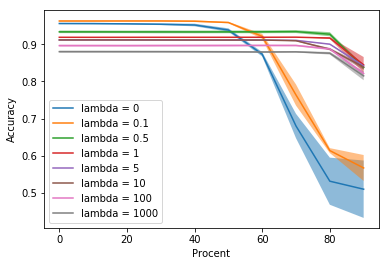

In [64]:
for k,lam in enumerate(lamb):
    acc_delete.append(None)
    loss_fn_nets =[]
    nets = []
    optimizer_nets = []
    mu_glob = []
    sigma_glob = []
    prune_coef_glob = []
    init_nets_output =  init_nets(loss_fn_nets)
    train_nets(lam, init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4])
    #graph_loss_func()
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])
graph(acc_delete,lamb)
save(acc_delete)


NameError: name 'i' is not defined